In [1]:
#%pip install scikit-learn
#%pip install matplotlib-venn

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, pipeline
from sklearn.metrics import accuracy_score, f1_score
import json
from datasets import load_dataset, Split

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
rlhf = 'movies-all'

In [4]:
dataset = load_dataset("csv", data_files=f"{rlhf}.csv", split=Split.ALL)

In [5]:
dataset

Dataset({
    features: ['adult', '28', '12', '16', '35', '80', '99', '18', '10751', '14', '36', '27', '10402', '9648', '10749', '878', '10770', '53', '10752', '37', 'overview'],
    num_rows: 131262
})

In [6]:
if rlhf == 'movie' or rlhf == 'movies-all':
    labels = [ '28', '53', '35' ]
#{'id': 28, 'name': 'Action'} {'id': 53, 'name': 'Thriller'} {'id': 35, 'name': 'Comedy'}
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [7]:
data = []
empties = 0
for d in dataset:
    # if not d['isAdult']:
    #     continue
    # this caused a throw in tokenizer
    if d['overview'] is None:
        empties += 1
        continue

    # i think this makes it where ones not in labels dont get added
    for label in labels:
        if d[label]:
            data.append({ 'category': label, 'text': d['overview'], 'label': label2id[label] })

df_data = pd.DataFrame(data)
print(empties)
display(df_data)
print(   df_data.category.value_counts()   )
    

10599


,category,text,label
0,28,Characters from different backgrounds are thro...,0
1,53,Characters from different backgrounds are thro...,1
2,28,When a Delta Force special ops mission goes te...,0
3,53,When a Delta Force special ops mission goes te...,1
4,28,After a migrating duck family alights on their...,0
...,...,...,...
49108,53,A mentally troubled man becomes a serial rapis...,1
49109,53,"On the beaches of the Caribbean, Private leads...",1
49110,53,Jesse Jane finds herself infatuated with a bud...,1
49111,53,"Linda Forrester, an FBI agent, is sent to Flor...",1


category
53    21936
35    17260
28     9917
Name: count, dtype: int64


In [8]:
def conv(mask):
    return format(mask, f'#0{len(labels)+2}b')[2:]

# dont do zero
# should be l!, but this is fine
total = 0
sizes = { conv(i): 0 for i in range(1, 2**len(labels)) }
for d in dataset:
    mask = 0
    for i, l in enumerate(labels):
        if d[l] == True:
            mask |= 2**i
    if mask != 0:
        sizes[conv(mask)] += 1
    total+=1
print(sizes, total)

{'001': 5242, '010': 19786, '011': 2849, '100': 15245, '101': 1688, '110': 364, '111': 221} 131262


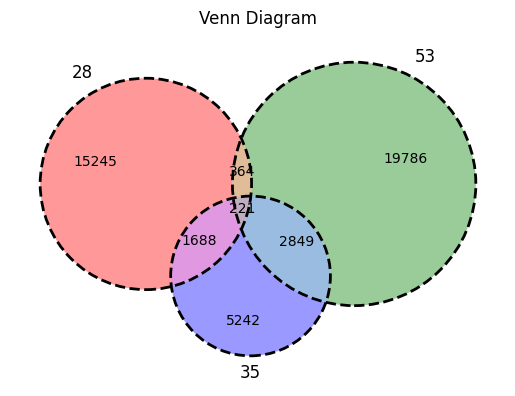

In [9]:
# sizes = { '100': 20, '010': 25, '001': 30, '110': 35, '101': 40, '011': 45, '111': 50 }
# 001 010 011 100 101 110 111
venn = venn3(subsets = sizes, set_labels = labels)
venn_circles = venn3_circles(subsets = sizes, linestyle = '--')

plt.title('Venn Diagram')
plt.show()

In [10]:
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels), id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
SIZE = df_data.shape[0]

train_texts= list(df_data.text[:SIZE//2])
val_texts=   list(df_data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(df_data.text[(3*SIZE)//4:])

train_labels= list(df_data.label[:SIZE//2])
val_labels=   list(df_data.label[SIZE//2:(3*SIZE)//4])
test_labels=  list(df_data.label[(3*SIZE)//4:])

print(   len(train_texts), len(val_texts), len(test_texts)   )

24556 12278 12279


In [12]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings   = tokenizer(val_texts,   truncation=True, padding=True)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True)

In [13]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset   = MyDataset(val_encodings,   val_labels)
test_dataset  = MyDataset(test_encodings,  test_labels)

In [15]:
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds  = pred.predictions.argmax(-1) 
    f1  = f1_score(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return {
        'Accuracy': acc,
        'F1': f1
    }

In [16]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir=f'{rlhf}-model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch",
    ## fp16=True
    #load_best_model_at_end=True
)

In [17]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [18]:
res_train = trainer.train()
print(res_train)

Step,Training Loss,Validation Loss,Accuracy,F1
50,1.043200,1.250353,0.467910,0.250507
100,0.882500,1.241473,0.466200,0.260816
150,0.809200,1.139194,0.455123,0.258076
200,0.837000,1.079752,0.415133,0.259788
250,0.753000,1.133787,0.309252,0.240320
300,0.956100,1.151693,0.496416,0.264544
350,0.823600,1.171311,0.460417,0.263908
400,0.815500,0.946995,0.441440,0.271031
450,0.801800,1.108630,0.483141,0.262213
500,0.781000,1.129946,0.458381,0.264972


KeyboardInterrupt: 

In [ ]:
trainer.save_model(f'{rlhf}-model/final-trainer')
tokenizer.save_pretrained(f'{rlhf}-model/final-tokenizer')

In [ ]:
q = [trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

In [ ]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

In [ ]:
text = ""
print(predict(text))

## Predict

In [ ]:
model = BertForSequenceClassification.from_pretrained(f"{rlhf}-model/final-trainer")
tokenizer= BertTokenizerFast.from_pretrained(f"{rlhf}-model/final-tokenizer")

sent_kwargs = {
         "return_all_scores": True, 
         "function_to_apply": "none", 
         "batch_size": 16
}
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, **sent_kwargs)

In [ ]:
print(text)
r1 = nlp(text)
print(json.dumps(r1, indent='\t'))